In [1]:
# !pip install rdkit -qqq
# !pip install deepchem -qqq
# !pip install pyGPGO -qqq

# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/MDRinhib-test

In [2]:
# Enables a useful dataframe explorer in colab
#%load_ext google.colab.data_table
#%unload_ext google.colab.data_table

In [3]:
import pandas as pd
import numpy as np
import rdkit as rd
import tensorflow as tf

from deepchem import deepchem as dc # Needs to me imported weirdly in VS code
from deepchem.models import GraphConvModel

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

# Uncomment these for production scenarios. (included for reproducibility)
tf.random.set_seed(123)
np.random.seed(123)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


# Functions

In [4]:
def unique_ligands(list_of_structures):
    '''
    This function takes a list of structures that was docked in different conformations
    (ie. the same structure occurs several times) and returns a unique list of structures 
    '''

    unique_list_prop = []
    unique_list = []

    for x in list_of_structures:
        test = x.GetProp("FDA drugnames") + x.GetProp('s_i_glide_gridfile')
        if test not in unique_list_prop:
            unique_list_prop.append(test)
            unique_list.append(x)
    return unique_list


def data_for_receptor(df, receptor_name, seed=1):
    '''
    This function takes the dataframe created for all receptors and returns
    training, validation and test data that can be used in a GraphConvModel.
    '''
    
    # This code takes the initial df and republish it with data only on one receptor
    df_receptor =  df[[receptor_name, receptor_name+'_mol']]
    # Applying a mask to remove 0 values.
    mask = df_receptor[receptor_name+'_mol'] == 0
    df_receptor = df_receptor.drop(df[mask].index)

    feat = dc.feat.ConvMolFeaturizer()
    X = feat.featurize(df_receptor[receptor_name+'_mol'])
    y = df_receptor[receptor_name].to_numpy()
    ids = df_receptor.index

    # Create dataset for deepchem
    dataset = dc.data.NumpyDataset(X=X, y=y, ids=ids)

    # Transform the output data for regression
    transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)
    dataset = transformer.transform(dataset)

    # split data
    splitter = dc.splits.RandomSplitter()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=seed,
    )

    return train_dataset, valid_dataset, test_dataset, transformer

# Import data

In [5]:
# Read sdf file with ligands docked to protein
suppl = Chem.SDMolSupplier('All_proteins_total.sdf')

# Put each ligand into list
mols_docked = [x for x in suppl]
print("Total number of FDA drug conformations successfully docked: " + str(len(mols_docked)))

unique_mols_docked = unique_ligands(mols_docked)
print("Number of FDA drugs successfully docked: " + str(len(unique_mols_docked)))

Total number of FDA drug conformations successfully docked: 30861
Number of FDA drugs successfully docked: 10151


In [6]:
mollist = [] # list of uniquely docked mol objects for featurization

# Creates a list of lists with information on
# Transporter name and site
# Molecule name
# Docking score
for mol in unique_mols_docked:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp('FDA drugnames'), float(mol.GetProp('r_i_glide_gscore')), mol])

df_initial = pd.DataFrame.from_records(mollist)
#df = df.pivot(index=1, columns=0, values=[2,3])

In [7]:
mollist = [] # list of uniquely docked mol objects for featurization

# Creates a list of lists with information on
# Transporter name and site
# Molecule name
# Docking score
for mol in unique_mols_docked:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp('FDA drugnames'), float(mol.GetProp('r_i_glide_gscore')), mol])

df = pd.DataFrame.from_records(mollist)
df = df.pivot(index=1, columns=0, values=[2,3])

receptors = []

# The following code fetches receptor names and lists them to be applied as columns in the dataFrame
for rec in df.keys():
    receptors.append(rec[1][11:15])

no_receptors = int(len(receptors)/2)
receptor_scores = []

for i in range(len(receptors)):
    if i >= no_receptors:
        receptors[i] = receptors[i] + "_mol"
    else:
        receptor_scores.append(receptors[i])

df.columns = receptors

# Rounds numbers in the dataFrame to 1 decimal
for rec in receptor_scores:
    df[rec] = pd.to_numeric(df[rec]).round(1)

# Replaces Nan values with 0
df = df.fillna(0)

# Global Hyper Parameters and metric

In [55]:
# Global metric
metric = dc.metrics.Metric(dc.metrics.rms_score)
metrics = [
    dc.metrics.Metric(dc.metrics.rms_score),
    dc.metrics.Metric(dc.metrics.mean_absolute_error),
]

# Global hyperparameters
n_feat = 75
batch_size = 32
learning_rate = 0.001
#learning_rate = dc.models.optimizers.ExponentialDecay(0.0002, 0.09, 100)
tasks = 1
epochs = 100
callback_interval = epochs*5

# Models for each receptor

In [9]:
models = []

for curr_recept in receptors[0:11]:
    print('Computing model for', curr_recept)
    train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, curr_recept, seed=1)
    callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=callback_interval, metrics=metrics, transformers=[transformer])
    model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
    model.fit(train_dataset, nb_epoch=epochs, callbacks=callback)
    models.append([model, train_dataset, valid_dataset, test_dataset, transformer, curr_recept])
    print('')

Computing model for BCRP
Step 125 validation: rms_score=2.19962 mean_absolute_error=1.84036
Step 250 validation: rms_score=1.97238 mean_absolute_error=1.54515
Step 375 validation: rms_score=1.94902 mean_absolute_error=1.46774
Step 500 validation: rms_score=1.77486 mean_absolute_error=1.30035

Computing model for MDR1
Step 125 validation: rms_score=1.92777 mean_absolute_error=1.53121
Step 250 validation: rms_score=2.02152 mean_absolute_error=1.55837
Step 375 validation: rms_score=1.67931 mean_absolute_error=1.3042
Step 500 validation: rms_score=1.72426 mean_absolute_error=1.28119

Computing model for MRP1
Step 125 validation: rms_score=1.98701 mean_absolute_error=1.3924
Step 250 validation: rms_score=1.88703 mean_absolute_error=1.29038
Step 375 validation: rms_score=1.57309 mean_absolute_error=1.02668
Step 500 validation: rms_score=1.69908 mean_absolute_error=1.14307

Computing model for MRP2
Step 125 validation: rms_score=2.09405 mean_absolute_error=1.58182
Step 250 validation: rms_sco

In [45]:
# train_scores = models[0].evaluate(train_dataset, metrics, [transformer])
# train_scores

for i, j, k, l, m, n in models:
    print(n, i.evaluate(k, metrics, [m]))

BCRP {'rms_score': 1.6936005323857284, 'mean_absolute_error': 1.2046598942383475}
MDR1 {'rms_score': 1.4564793478584988, 'mean_absolute_error': 1.1025134864060775}
MRP1 {'rms_score': 1.4979713172023197, 'mean_absolute_error': 0.9691739630955521}
MRP2 {'rms_score': 1.988924096223351, 'mean_absolute_error': 1.469544049449589}
MRP3 {'rms_score': 1.5352133846253935, 'mean_absolute_error': 1.0430956161540488}
MRP4 {'rms_score': 1.7862233154640794, 'mean_absolute_error': 1.2854928357260569}
MRP5 {'rms_score': 1.7948349018050533, 'mean_absolute_error': 1.4426651711049283}
MRP6 {'rms_score': 1.4320775980086806, 'mean_absolute_error': 0.9892102728719295}
MRP7 {'rms_score': 1.4628732796269368, 'mean_absolute_error': 1.036468602252263}
MRP8 {'rms_score': 1.7169103308280165, 'mean_absolute_error': 1.2916611317665345}
MRP9 {'rms_score': 2.0312752154445533, 'mean_absolute_error': 1.5089821426764776}


# BCRP

In [7]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'BCRP', seed=1)

In [8]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=0.001)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=callback_interval, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=epochs, callbacks=callback)

Step 125 validation: rms_score=2.08371 mean_absolute_error=1.61701
Step 250 validation: rms_score=2.25793 mean_absolute_error=1.83537
Step 375 validation: rms_score=1.85473 mean_absolute_error=1.45318
Step 500 validation: rms_score=1.77563 mean_absolute_error=1.37688


0.14140666961669923

In [29]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.3115504730616068, 'mean_absolute_error': 0.2318103743445174} 

Validation scores
{'rms_score': 1.4978781205960332, 'mean_absolute_error': 1.0738992577013764} 

test scores
{'rms_score': 1.4021435072297646, 'mean_absolute_error': 1.0548747923063195} 



In [30]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

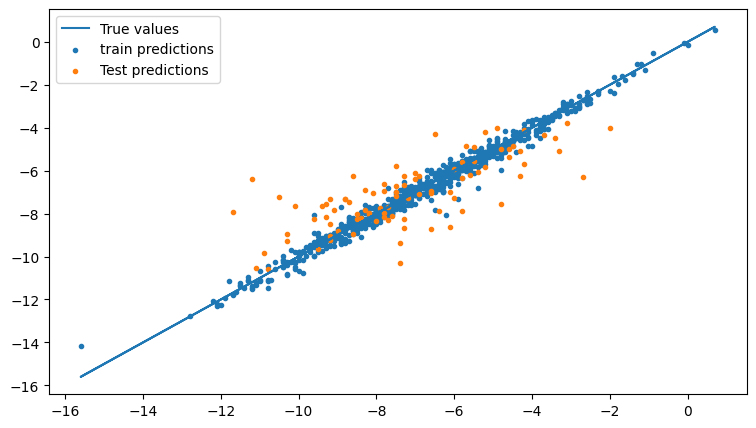

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')

plt.legend()

# MDR1

In [ ]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'MDR1', seed=1)

In [ ]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=75, callbacks=callback)

Step 100 validation: rms_score=2.47178 mean_absolute_error=1.9231
Step 200 validation: rms_score=2.20011 mean_absolute_error=1.70805
Step 300 validation: rms_score=2.08757 mean_absolute_error=1.55983
Step 400 validation: rms_score=2.00353 mean_absolute_error=1.54961
Step 500 validation: rms_score=1.92206 mean_absolute_error=1.54224
Step 600 validation: rms_score=1.84829 mean_absolute_error=1.48019
Step 700 validation: rms_score=1.83825 mean_absolute_error=1.47607
Step 800 validation: rms_score=1.78291 mean_absolute_error=1.41699
Step 900 validation: rms_score=1.78151 mean_absolute_error=1.39461
Step 1000 validation: rms_score=1.77766 mean_absolute_error=1.39745
Step 1100 validation: rms_score=1.7316 mean_absolute_error=1.35287
Step 1200 validation: rms_score=1.73443 mean_absolute_error=1.3331
Step 1300 validation: rms_score=1.7334 mean_absolute_error=1.33812
Step 1400 validation: rms_score=1.69617 mean_absolute_error=1.30911
Step 1500 validation: rms_score=1.67871 mean_absolute_error=1

0.27875694274902346

In [ ]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.8484559517736948, 'mean_absolute_error': 0.6292968675291181} 

Validation scores
{'rms_score': 1.6514642199264757, 'mean_absolute_error': 1.2724061406177023} 

test scores
{'rms_score': 1.8713831931163953, 'mean_absolute_error': 1.3839440076247504} 



In [ ]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

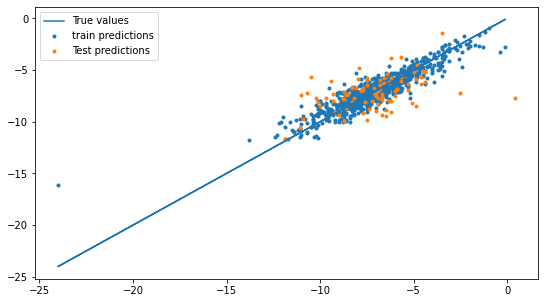

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')


plt.legend()

# MRP8

In [ ]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'MRP8', seed=1)

In [ ]:
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=100, metrics=metrics, transformers=[transformer])
model.fit(train_dataset, nb_epoch=50, callbacks=callback)

Step 100 validation: rms_score=2.1837 mean_absolute_error=1.67219
Step 200 validation: rms_score=2.09585 mean_absolute_error=1.56002
Step 300 validation: rms_score=1.9162 mean_absolute_error=1.3733
Step 400 validation: rms_score=1.78714 mean_absolute_error=1.29926
Step 500 validation: rms_score=1.76486 mean_absolute_error=1.25343
Step 600 validation: rms_score=1.73957 mean_absolute_error=1.25677
Step 700 validation: rms_score=1.71627 mean_absolute_error=1.25173
Step 800 validation: rms_score=1.72861 mean_absolute_error=1.22593
Step 900 validation: rms_score=1.70905 mean_absolute_error=1.21143
Step 1000 validation: rms_score=1.73824 mean_absolute_error=1.2232
Step 1100 validation: rms_score=1.73665 mean_absolute_error=1.22432
Step 1200 validation: rms_score=1.75792 mean_absolute_error=1.23674


0.3930514907836914

In [ ]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, metrics, [transformer])
valid_scores = model.evaluate(valid_dataset, metrics, [transformer])
test_scores = model.evaluate(test_dataset, metrics, [transformer])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("Test scores")
print(test_scores, "\n")

Evaluating model
Train scores
{'rms_score': 0.9272240319316517, 'mean_absolute_error': 0.6478189758716091} 

Validation scores
{'rms_score': 1.757922778837715, 'mean_absolute_error': 1.2367418140493414} 

Test scores
{'rms_score': 1.6723099153114467, 'mean_absolute_error': 1.365366083003105} 



In [ ]:
train_preds = transformer.untransform(model.predict(train_dataset))
test_preds = transformer.untransform(model.predict(test_dataset))
train_plot_dataset = transformer.untransform(train_dataset.y)
test_plot_dataset = transformer.untransform(test_dataset.y)

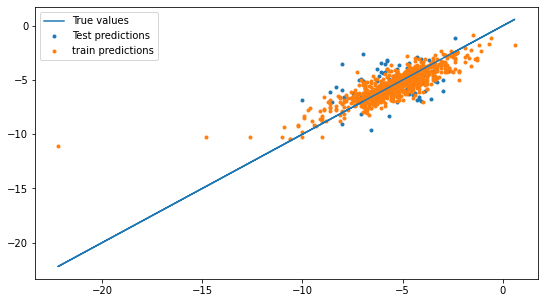

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset, train_plot_dataset, label='True values')
plt.scatter(test_plot_dataset, test_preds, marker='.', label='Test predictions')
plt.scatter(train_plot_dataset, train_preds, marker='.', label='train predictions')

plt.legend()

# Hyperparameter Optimization

## Grid search

In [16]:
optimizer = dc.hyper.GridHyperparamOpt(dc.models.GraphConvModel)

params_dict = {
    'n_tasks': [1],
    'batch_size': [8, 128, 256],
    'number_atom_features': [10, 100, 1000],
    'learning_rate': [0.1, 0.001, 0.0001],
    'mode': ['regression']
}

In [17]:
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict=params_dict,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    metric=metric,
    output_transformers=[transformer],
    use_max=False,
    nb_epoch=10,
)

In [22]:
best_hyperparams

{'n_tasks': 1,
 'batch_size': 8,
 'number_atom_features': 1000,
 'learning_rate': 0.001,
 'mode': 'regression'}

In [21]:
all_results

{'_batch_size_8_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_10': 9.580108028163604,
 '_batch_size_8_learning_rate_0.001000_moderegression_n_tasks_1_number_atom_features_10': 2.0526416321769423,
 '_batch_size_8_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_10': 2.11309152431345,
 '_batch_size_8_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_100': 4.375742604809805,
 '_batch_size_8_learning_rate_0.001000_moderegression_n_tasks_1_number_atom_features_100': 1.771346389797354,
 '_batch_size_8_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_100': 2.083827199251206,
 '_batch_size_8_learning_rate_0.100000_moderegression_n_tasks_1_number_atom_features_1000': 6.828290064226667,
 '_batch_size_8_learning_rate_0.001000_moderegression_n_tasks_1_number_atom_features_1000': 1.7362894953868238,
 '_batch_size_8_learning_rate_0.000100_moderegression_n_tasks_1_number_atom_features_1000': 1.9598477629360083,
 '_batch

## Gaussian Process

Example of how to use the Gaussian Process Hyperparameter optimization feature in DeepChem.

https://github.com/gitconnoisseur/toxicity-model/blob/9d04e1d234e87bc2402bdd7b4c9c1a88d9633c36/graph_conv.ipynb

In [14]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'BCRP', seed=1)

In [24]:
def model_builder(**model_params):
    return GraphConvModel(n_tasks=tasks, mode='regression')

optimizer = dc.hyper.GaussianProcessHyperparamOpt(model_builder=model_builder, max_iter=30)

params_dict = {
    "number_atom_features": 75,
    "learning_rate": 0.001,
    "batch_size": 64,
    "graph_conv_layers": [128,128],
    "dense_layer_size": 128,
}

best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict=params_dict,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    output_transformers=[transformer],
    metric=metric,
    use_max=False,
    nb_epoch=10,
)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.24000000e+02 1.80226207e-03 1.44000000e+02 4.30000000e+02]. 	  -2.5262534976379833 	 -2.3444400300648858
init   	 [5.00000000e+01 3.44961385e-04 2.27000000e+02 2.25000000e+02]. 	  -2.3444400300648858 	 -2.3444400300648858
init   	 [1.71000000e+02 2.85539314e-04 1.75000000e+02 1.74000000e+02]. 	  -2.520295945781984 	 -2.3444400300648858


KeyboardInterrupt: 

# Optimizing for BCRP

In [35]:
train_dataset, valid_dataset, test_dataset, transformer = data_for_receptor(df, 'BCRP', seed=1)

In [40]:
epochs = 30

model = GraphConvModel(
    n_tasks=tasks,
    batch_size=32, 
    mode='regression', 
    number_atom_features=75, 
    learning_rate=0.01,
    graph_conv_layers=[128, 128],
    dense_layer_size=128,
)

callback = dc.models.ValidationCallback(
    dataset=valid_dataset, 
    interval=epochs, 
    metrics=metrics, 
    transformers=[transformer]
)

model.fit(
    train_dataset, 
    nb_epoch=epochs, 
    callbacks=callback
)

Step 30 validation: rms_score=2.51562 mean_absolute_error=2.07244
Step 60 validation: rms_score=3.26787 mean_absolute_error=2.89454
Step 90 validation: rms_score=2.48903 mean_absolute_error=2.09522
Step 120 validation: rms_score=2.15712 mean_absolute_error=1.58179
Step 150 validation: rms_score=2.05482 mean_absolute_error=1.612
Step 180 validation: rms_score=2.72208 mean_absolute_error=2.12588
Step 210 validation: rms_score=1.82354 mean_absolute_error=1.44317
Step 240 validation: rms_score=1.76258 mean_absolute_error=1.35852
Step 270 validation: rms_score=1.67763 mean_absolute_error=1.26575
Step 300 validation: rms_score=1.64391 mean_absolute_error=1.19881
Step 330 validation: rms_score=1.63074 mean_absolute_error=1.26039
Step 360 validation: rms_score=1.74508 mean_absolute_error=1.34726
Step 390 validation: rms_score=1.68474 mean_absolute_error=1.29024
Step 420 validation: rms_score=1.85763 mean_absolute_error=1.40175
Step 450 validation: rms_score=1.8904 mean_absolute_error=1.53189
S

0.2179229948255751

# Multitask model

As it doesn't make sense to use different docking configurations of the molecules, each molecule is converted to a SMILES string and then they are made back to RDkit objects

In [57]:
# this block takes the df and replaces the molecules with the corresponding smiles, and converts them 'back' to
# rdkit objects, this time we know that no unnessecary structural information is included.
def mol_to_smiles(row, primary_col):
    cols = row.index[row.index.get_loc(primary_col) + 1:]
    for col in [primary_col] + list(cols):
        try:
            return Chem.MolToSmiles(row[col])
        except:
            continue
    return None

def create_smiles_dataframe(df, primary_col, receptors):
    df_smiles = df.loc[:, receptors[:11]]
    df_smiles['SMILES'] = df.apply(lambda row: mol_to_smiles(row, primary_col), axis=1)
    return df_smiles

primary_col = 'BCRP_mol'
df_smiles = create_smiles_dataframe(df, primary_col, receptors)

In [58]:
# Convert the smiles into rdkit objects.
df_smiles['molecule'] = df_smiles['SMILES'].apply(Chem.MolFromSmiles)
df_smiles

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9,SMILES,molecule
1,,,,,,,,,,,,,
8-HOUR BAYER; ASPIRIN,-5.3,-6.4,-5.1,-4.9,-4.1,-5.1,-9.3,-4.1,-3.5,-4.2,-6.6,CC(=O)Oc1ccccc1C(=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
8-MOP; METHOXSALEN,-8.0,-6.4,-4.8,-3.9,-4.7,-4.7,-3.8,-3.9,-4.7,-5.7,-3.4,COc1c2occc2cc2ccc(=O)oc12,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,-10.7,-7.9,-6.9,-7.9,-6.9,-8.5,-6.2,-4.4,-9.7,-9.5,CNC1=Nc2ccc(Cl)cc2C(c2ccccc2)=[N+]([O-])C1,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,-6.3,-5.9,-6.7,-5.0,-5.0,-7.4,-5.6,-5.2,-4.6,-6.7,Nc1ccn([C@H]2CS[C@H](CO)O2)c(=O)n1,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,-7.6,-5.5,-4.6,-5.3,-5.1,-6.6,-4.4,-5.0,-3.8,-5.0,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,-8.6,-5.2,-5.8,-5.9,-6.9,-7.5,-3.2,-3.9,-5.8,-5.9,CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
ZYDELIG; IDELALISIB,-9.3,-8.5,-6.4,-5.2,-6.1,-8.2,-7.2,-6.0,-5.4,-6.3,-6.0,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
ZYFLO CR; ZILEUTON,-7.4,-7.6,-5.7,-7.1,-6.6,-5.9,-6.3,-5.5,-5.3,-5.6,-6.7,C[C@@H](c1cc2ccccc2s1)N(O)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...


In [59]:
# Featurize and ready data
feat = dc.feat.ConvMolFeaturizer()
X = feat.featurize(df_smiles['molecule'])
y = df_smiles.loc[:,receptors[:11]].to_numpy()
ids = df_smiles.index

dataset = dc.data.NumpyDataset(X=X, y=y, ids=ids)

In [60]:
# Split the data
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=1,
)

In [61]:
tasks = len(dataset.y[0])

In [62]:
# Build the model
model = GraphConvModel(n_tasks=tasks, batch_size=batch_size, mode='regression', number_atom_features=n_feat, learning_rate=learning_rate)
callback = dc.models.ValidationCallback(dataset=valid_dataset, interval=callback_interval, metrics=metrics)
model.fit(train_dataset, nb_epoch=epochs, callbacks=callback)

Step 500 validation: rms_score=1.67235 mean_absolute_error=1.14635
Step 1000 validation: rms_score=1.72349 mean_absolute_error=1.19245
Step 1500 validation: rms_score=1.63507 mean_absolute_error=1.151
Step 2000 validation: rms_score=1.66882 mean_absolute_error=1.14568


0.8985281372070313

In [122]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

# To get the predictions and true values for BCRP we must get the first item from each list
receptor_no = 0
train_preds_BCRP = [sublist[receptor_no] for sublist in train_preds]
test_preds_BCRP = [sublist[receptor_no] for sublist in test_preds]
train_plot_dataset_BCRP = [sublist[receptor_no] for sublist in train_dataset.y]
test_plot_dataset_BCRP = [sublist[receptor_no] for sublist in test_dataset.y]

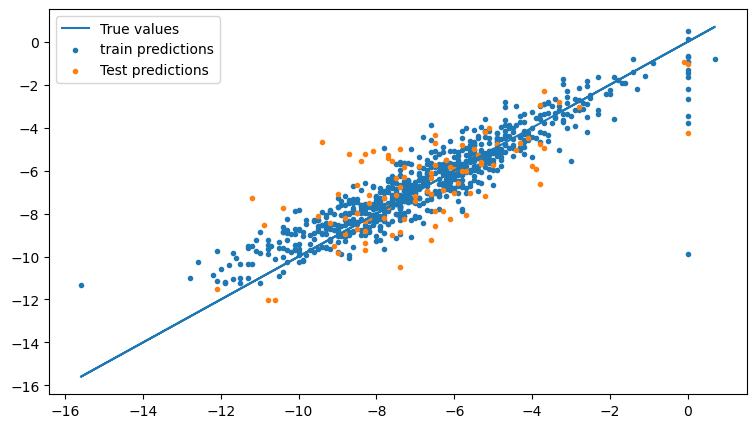

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(train_plot_dataset_BCRP, train_plot_dataset_BCRP, label='True values')
plt.scatter(train_plot_dataset_BCRP, train_preds_BCRP, marker='.', label='train predictions')
plt.scatter(test_plot_dataset_BCRP, test_preds_BCRP, marker='.', label='Test predictions')

plt.legend()

Checking why a host of values are almost zero.

In [78]:
zero_indices = [index for index, value in enumerate(train_preds_BCRP) if value > -1]
print(zero_indices)

[41, 96, 127, 193, 287, 574, 578, 617, 676]


In [125]:
problematic_mols = [train_dataset.ids[index] for index in zero_indices]
problematic_mols

['TAO; TROLEANDOMYCIN',
 'MEMANTINE; MEMANTINE',
 'XIFAXAN; RIFAXIMIN',
 'ETHAMBUTOL HYDROCHLORIDE; ETHAMBUTOL HYDROCHLORIDE',
 'CHOLEDYL; OXTRIPHYLLINE',
 'AMANTADINE HYDROCHLORIDE; AMANTADINE HYDROCHLORIDE',
 'GUANIDINE HYDROCHLORIDE; GUANIDINE HYDROCHLORIDE',
 'RAPAMUNE; SIROLIMUS',
 'TORISEL; TEMSIROLIMUS']

In [127]:
df_smiles.loc[problematic_mols]

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9,SMILES,molecule
1,,,,,,,,,,,,,
TAO; TROLEANDOMYCIN,0.0,0.0,-1.9,-6.3,0.4,0.0,-6.1,-0.9,-3.1,-3.4,-7.8,CO[C@H]1C[C@H](O[C@H]2[C@H](C)[C@@H](O[C@@H]3O...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
MEMANTINE; MEMANTINE,0.7,-6.2,-4.3,0.0,-4.0,-3.8,-4.2,-3.6,-4.4,-3.1,-2.9,C[C@]12C[C@@H]3C[C@](C)(C1)C[C@@]([NH3+])(C3)C2,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
XIFAXAN; RIFAXIMIN,0.0,0.0,-4.9,-4.8,0.0,0.0,-6.2,0.0,-5.2,-6.1,0.0,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c([O-])c4c(O)c(c...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
ETHAMBUTOL HYDROCHLORIDE; ETHAMBUTOL HYDROCHLORIDE,-0.9,-2.4,-1.2,-3.2,-3.8,-2.4,-1.4,-5.8,-3.8,-2.8,-2.1,CC[C@@H](CO)[NH2+]CC[NH2+][C@@H](CC)CO,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
CHOLEDYL; OXTRIPHYLLINE,-0.0,-2.3,-2.6,-2.3,-3.1,-2.5,-2.7,-2.5,-3.3,-1.9,-3.0,C[N+](C)(C)CCO,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
AMANTADINE HYDROCHLORIDE; AMANTADINE HYDROCHLORIDE,0.0,-2.0,-3.6,0.0,-1.7,0.0,-1.3,-1.2,-3.4,-3.1,-1.5,[NH3+][C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
GUANIDINE HYDROCHLORIDE; GUANIDINE HYDROCHLORIDE,-1.4,-1.3,-2.6,-1.3,-3.9,-3.4,-1.4,-2.4,-1.3,-4.0,-1.2,NC(N)=[NH2+],<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
RAPAMUNE; SIROLIMUS,0.0,0.0,-8.5,-7.7,-6.7,0.0,-5.8,0.0,-5.7,-6.1,0.0,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...
TORISEL; TEMSIROLIMUS,0.0,0.0,-5.6,-6.9,-7.0,-2.3,0.0,0.0,-5.1,-7.2,0.0,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,<rdkit.Chem.rdchem.Mol object at 0x00000237DB5...


These values are indeed almost zero values, so we'll keep them in the model.
One important observation from this is that the model didn't seem to pick this up on the single task model.